## Source : https://www.kaggle.com/datasets/brandao/diabetes/data

## About Dataset

### Basic Explanation

It is important to know if a patient will be readmitted in some hospital. The reason is that you can change the treatment, in order to avoid a readmission.

In this database, you have 3 different outputs:

1.  No readmission;
2.  A readmission in less than 30 days (this situation is not good, because maybe your treatment was not appropriate);
3.  A readmission in more than 30 days (this one is not so good as well the last one, however, the reason can be the state of the patient.

In this context, you can see different objective functions for the problem. You can try to figure out situations where the patient will not be readmitted, or if their are going to be readmitted in less than 30 days (because the problem can the the treatment), etc… Make your choice and let's help them creating new approaches for the problem.

### Content

"The data set represents 10 years (1999-2008) of clinical care at 130 US hospitals and integrated delivery networks. It includes over 50 features representing patient and hospital outcomes. Information was extracted from the database for encounters that satisfied the following criteria.

1.  It is an inpatient encounter (a hospital admission).
2.  It is a diabetic encounter, that is, one during which any kind of diabetes was entered to the system as a diagnosis.
3.  The length of stay was at least 1 day and at most 14 days.
4.  Laboratory tests were performed during the encounter.
5.  Medications were administered during the encounter.

The data contains such attributes as patient number, race, gender, age, admission type, time in hospital, medical specialty of admitting physician, number of lab test performed, HbA1c test result, diagnosis, number of medication, diabetic medications, number of outpatient, inpatient, and emergency visits in the year before the hospitalization, etc."

In [64]:
import pandas as pd
import numpy as np
import requests, zipfile, io
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from utility import *


In [2]:
if not os.path.exists("../../data"):
    os.mkdir("../../data")

DATA_PATH = "../../data/diabetes_data"
if not os.path.exists(DATA_PATH):
    os.mkdir(DATA_PATH)
    

# Download data

In [3]:
url = "https://archive.ics.uci.edu/static/public/296/diabetes+130-us+hospitals+for+years+1999-2008.zip"
response = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(response.content))
z.extractall(DATA_PATH)


# Load data

In [4]:
data_loaded = pd.read_csv(os.path.join(DATA_PATH, "diabetic_data.csv"))
data_loaded.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


# Pre-process data

There are 71515 unique patients in the data


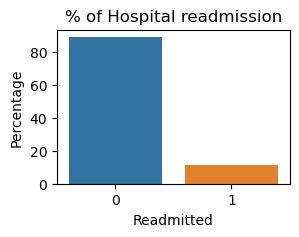

In [5]:

data_preprocessed = preprocess_data(data_loaded)

data_preprocessed.drop(['encounter_id','patient_nbr'],axis=1,inplace=True)


# Getting Dependent and independent variables from data

In [6]:
X = data_preprocessed.drop('readmitted',axis=1)

y = data_preprocessed['readmitted']


# Splitting data into train and test

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)



# Data normalization

In [8]:
SC = StandardScaler()
X_train_scaled = pd.DataFrame(SC.fit_transform(X_train),columns=X_train.columns)
X_test_scaled = pd.DataFrame(SC.transform(X_test),columns=X_test.columns)

print("There are {} training data ".format(X_train.shape[0]))
print("There are {} testing data ".format(X_test.shape[0]))


There are 91586 training data 
There are 10177 testing data 


# Train Logistic classifier

In [60]:
%%time

train_sample_wt = compute_sample_weight(class_weight='balanced', y=y_train)

LR = LogisticRegression()

# LR = LogisticRegression(C=500.0/X_train_scaled.shape[0], 
#                         penalty="elasticnet",
#                         l1_ratio=0.5,
#                         solver="saga", 
#                         tol=0.001)

LR.fit(X_train_scaled, y_train, sample_weight=train_sample_wt)


CPU times: user 668 ms, sys: 3.58 ms, total: 672 ms
Wall time: 676 ms


LogisticRegression(C=0.0054593496822658485, l1_ratio=0.5, penalty='elasticnet',
                   solver='saga', tol=0.001)

# Evaluate the model - Confusion matrix

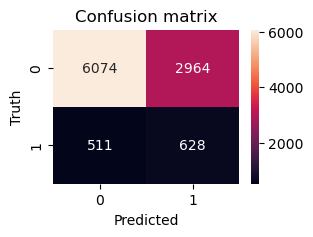

In [69]:
y_pred = LR.predict(X_test_scaled)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(3,2))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title("Confusion matrix")
plt.show()


# Evaluate the model - Classification report

In [70]:

print("Classification Report:\n", classification_report(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.67      0.78      9038
           1       0.17      0.55      0.27      1139

    accuracy                           0.66     10177
   macro avg       0.55      0.61      0.52     10177
weighted avg       0.84      0.66      0.72     10177



# Evaluate the model - ROC-AUC

AUC score =  0.6664508510646979


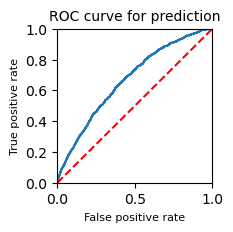

In [61]:
y_pred_prob = LR.predict_proba(X_test_scaled)
auc = roc_auc_score(y_test, y_pred_prob[:,1])
print("AUC score = ", auc)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:,1])

plt.figure(figsize=(2,2))
plt.plot(fpr, tpr)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.plot([0, 1], [0, 1],'r--')
plt.title('ROC curve for prediction', fontsize = 10)
plt.xlabel('False positive rate', fontsize = 8)
plt.ylabel('True positive rate', fontsize = 8)
plt.show()
